### Import Necessary Libraries

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import json
from pandas.io.json import json_normalize

### Import JSON data

In [76]:
df = pd.read_json('logins.json')
df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


### Data Manipulation

In [14]:
# Check for missing values

df.isnull().values.any()

False

In [77]:
# Check the types of input

df.dtypes

login_time    datetime64[ns]
dtype: object

In [79]:
# Create a new column of number of count

df['count'] = 1
df = df.set_index('login_time')
df

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


In [80]:
# Aggregating the data by 15 mins period

agg_15m = pd.DataFrame(df['count'].resample('15T').sum())
agg_15m

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [84]:
# Separate the date, time and the day of week

agg_15m['time_hour'] = [d.time() for d in agg_15m.index]
agg_15m['date_info'] = [d.date() for d in agg_15m.index]
agg_15m.reset_index(inplace=True)
agg_15m['weekday'] = agg_15m[['login_time']].apply(lambda x: dt.datetime.strftime(x['login_time'], '%A'), axis=1)
agg_15m

,login_time,count,time_hour,date_info,weekday
0,1970-01-01 20:00:00,2,20:00:00,1970-01-01,Thursday
1,1970-01-01 20:15:00,6,20:15:00,1970-01-01,Thursday
2,1970-01-01 20:30:00,9,20:30:00,1970-01-01,Thursday
3,1970-01-01 20:45:00,7,20:45:00,1970-01-01,Thursday
4,1970-01-01 21:00:00,1,21:00:00,1970-01-01,Thursday
...,...,...,...,...,...
9783,1970-04-13 17:45:00,5,17:45:00,1970-04-13,Monday
9784,1970-04-13 18:00:00,5,18:00:00,1970-04-13,Monday
9785,1970-04-13 18:15:00,2,18:15:00,1970-04-13,Monday
9786,1970-04-13 18:30:00,7,18:30:00,1970-04-13,Monday


In [85]:
agg_15m.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


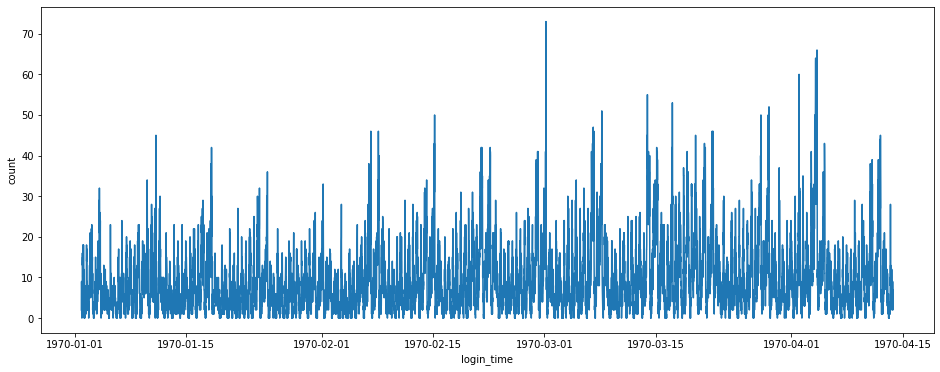

In [30]:
# Visualize the count of the 15-minutes period

plt.figure(figsize=(16,6))
sns.lineplot(y='count', x='login_time', data=agg_15m)

We see that the graph is hard to decipher as it has 9,788 data points but we see the maximum point somewhere in the month of March and if I can guess, there is a trend between weekdays. We will dig further to confirm this hypothesis. 

#### Group By Date

In [39]:
by_day = agg_15m.groupby(['date_info']).sum()
by_day.reset_index(inplace=True)
datetimes = pd.to_datetime(by_day['date_info'])
by_day['date_info'] = datetimes.dt.month.astype(str) + ' - ' + datetimes.dt.day.astype(str)
by_day

,date_info,count
0,1 - 1,112
1,1 - 2,681
2,1 - 3,793
3,1 - 4,788
4,1 - 5,459
...,...,...
98,4 - 9,818
99,4 - 10,1009
100,4 - 11,1352
101,4 - 12,1409


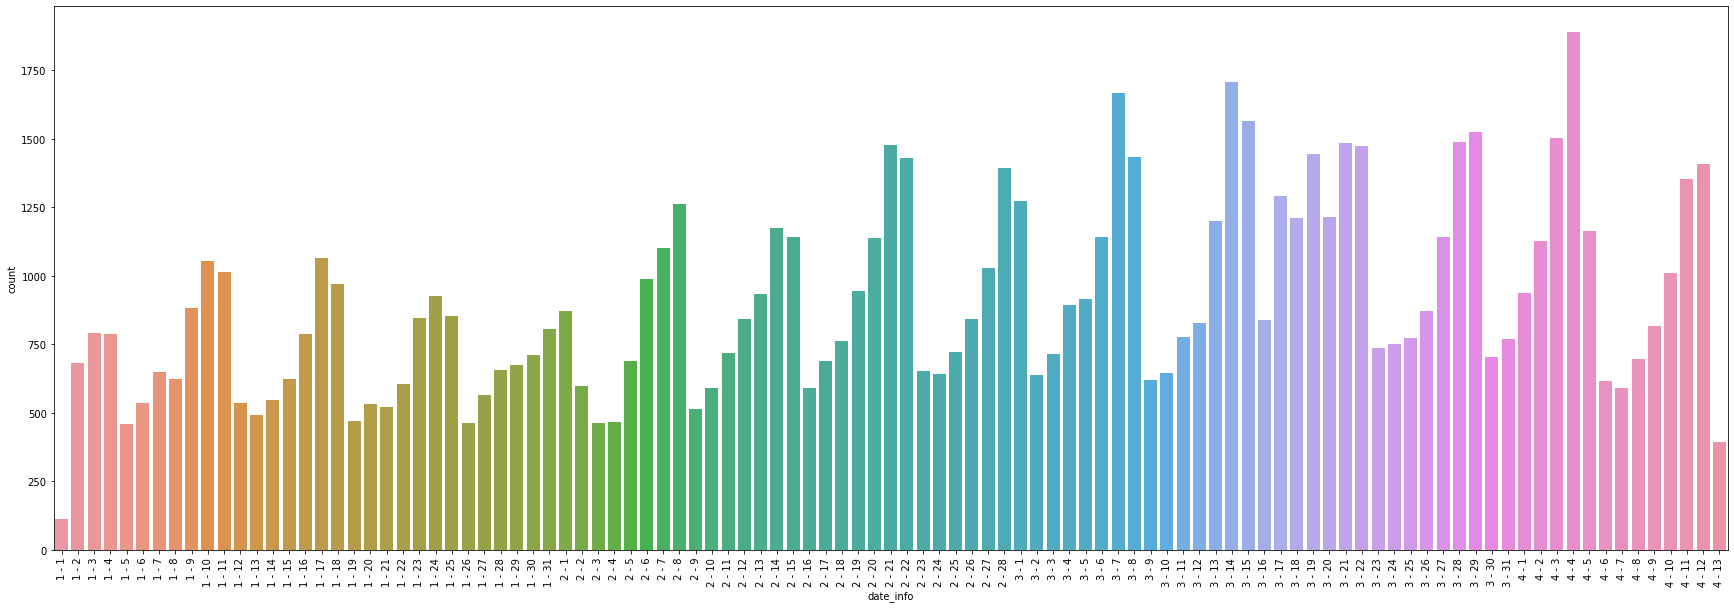

In [64]:
plt.figure(figsize=(30,10))
ax = sns.barplot(y='count', x='date_info', data=by_day)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

By refining it by date, we can see better picture on the trend of the login time. Definitely, there is a trend on the day of the week.

#### Group By Day of Week

In [86]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
by_weekday = agg_15m.groupby(['weekday']).sum().reindex(cats)
by_weekday.reset_index(inplace=True)
by_weekday

,weekday,count
0,Monday,8823
1,Tuesday,9268
2,Wednesday,10339
3,Thursday,11960
4,Friday,15208
5,Saturday,19377
6,Sunday,18167


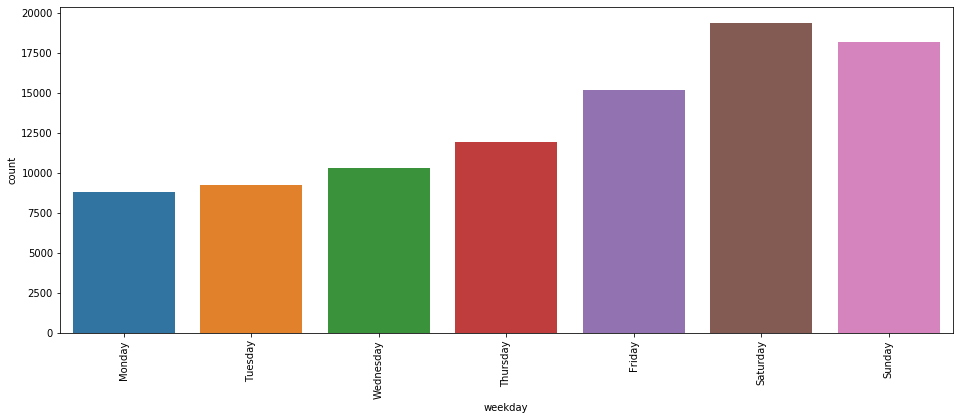

In [87]:
plt.figure(figsize=(16,6))
ax = sns.barplot(y='count', x='weekday', data=by_weekday)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

There is a difference in number of logins in weekday vs weekend.

#### Group By Hour

In [72]:
by_hour = agg_15m.groupby(['time_hour']).sum()
by_hour.reset_index(inplace=True)
by_hour

,time_hour,count
0,00:00:00,1439
1,00:15:00,1547
2,00:30:00,1525
3,00:45:00,1482
4,01:00:00,1549
...,...,...
91,22:45:00,1637
92,23:00:00,1573
93,23:15:00,1552
94,23:30:00,1456


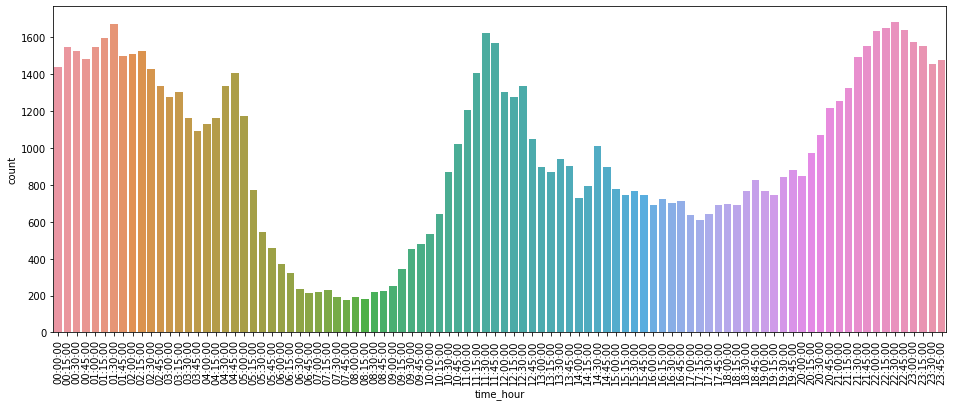

In [73]:
plt.figure(figsize=(16,6))
ax = sns.barplot(y='count', x='time_hour', data=by_hour)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)